# Принятие решений в бизнесе на основе данных. Анализ A/B-теста

**Цель исследования** - проанализировать результаты  A/B-теста.

**Задачи исследования** - для выполнения поставленной цели все данные загружены и предобработаны для анализа. Затем построены и проанализированы полученные графики и рассчитана статистическая значимость.

**Исходные данные:**

 -   результаты A/B-теста, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv. 

 
Таким образом, исследование пройдено в пять этапов:
 1. Обзор данных.
 2. Анализ кумулятивных метрик и построение графиков.
 3. Выявление и анализ выбросов.
 4. Статистическая значимость различий сырых и очищенных от выбросов данных.

#### СТЭК

In [24]:
import pandas as pd
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

## Обзор и предобработака данных

Прочтём данные из файлов с результатами A/B-тестирования:

In [25]:
def fst_imp(data):
    """This function is giving first impression of data. Also checking exact duplicates and blanks"""
    return (pd.set_option("max_colwidth", 120),
            display(data.head(3)),
            print(data.info()), 
            print('---------------------------------------------'),
            
            print("Количество явных дубликатов:", data.duplicated().sum()),
            print(" "),
            print("Наличие пропусков:"),
            display(pd.DataFrame(round(data.isna().mean()*100,2)).style.background_gradient('coolwarm')))

In [26]:
orders = pd.read_csv('orders.csv', sep=',')
fst_imp(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
---------------------------------------------
Количество явных дубликатов: 0
 
Наличие пропусков:


,0
transactionId,0.000000
visitorId,0.000000
date,0.000000
revenue,0.000000
group,0.000000


(None, None, None, None, None, None, None, None)

Ознакомимся с данными. Столбцы датафрейма orders:

- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

In [27]:
visitors = pd.read_csv('visitors.csv', sep=',')
fst_imp(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
---------------------------------------------
Количество явных дубликатов: 0
 
Наличие пропусков:


,0
date,0.000000
group,0.000000
visitors,0.000000


(None, None, None, None, None, None, None, None)

Столбцы датафрейма visitors:

- `date` — дата;
- `group`— группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

Методом to_datetime() превратим содержимое столбцов `date` в понятные для Python даты в датафреймах.

In [28]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%dT%H:%M:%S')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%dT%H:%M:%S')

Итак, даты в датафреймах приведены к нужному типу, теперь мы можем определить временные рамки проведения теста.

In [29]:
first_date = orders['date'].min()
last_date = orders['date'].max()
print('Временной горизонт в датафрейме "orders": ', first_date, 'по ', last_date)

first_date_v = visitors['date'].min()
last_date_v = visitors['date'].max()
print('Временной горизонт в датафрейме "visitors": ', first_date_v, 'по ', last_date_v)

Временной горизонт в датафрейме "orders":  2019-08-01 00:00:00 по  2019-08-31 00:00:00
Временной горизонт в датафрейме "visitors":  2019-08-01 00:00:00 по  2019-08-31 00:00:00


Далее, сгруппируем оба датафрейма по группам теста.

In [30]:
pivot_groups = orders.groupby('group').agg({'transactionId': 'count', 'visitorId': 'nunique'})
pivot_groups

,transactionId,visitorId
group,,
A,557,503
B,640,586


In [31]:
pivot_groups_visitors = visitors.groupby('group').agg({'visitors': 'sum'})
pivot_groups_visitors

,visitors
group,
A,18736
B,18916


Определим наличие пользователей, находящихся в двух группах одновременно. 

In [32]:
duplicates= orders.groupby('visitorId').agg({'group':'nunique'}).query('group>1')
print('Обнаружено количество дублирующихся пользователей одновременно в двух группах теста:',duplicates.shape[0])

Обнаружено количество дублирующихся пользователей одновременно в двух группах теста: 58


 Мы обнаружили 58 дубликатов. Их необходимо удалить из анализа. 

In [33]:
orders = orders[~orders['visitorId'].isin(duplicates.index)]
duplicates= orders.groupby('visitorId').agg({'group':'nunique'}).query('group>1')
print('После обработки количество дублирующихся пользователей одновременно в двух группах теста:',duplicates.shape[0])

После обработки количество дублирующихся пользователей одновременно в двух группах теста: 0


In [34]:
pivot_groups_f = orders.groupby('group').agg({'transactionId': 'count', 'visitorId': 'nunique'})
pivot_groups_f

,transactionId,visitorId
group,,
A,468,445
B,548,528


Таким образом, после удаления дубликатов у нас есть 445 уникальных покупателя в группе А и 528 в группе В. Теперь можно приступать к построению графиков.

### Анализ кумулятивных метрик

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм cumulativeData со столбцами:

- `date` — дата;
- `group` — группа A/B-теста (A или B);
- `orders` — кумулятивное количество заказов на указанную дату в указанной группе;
- `buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- `visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates():

In [35]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий.
Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, а группа теста равна группе из datesGroups:\
`orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]`

Агрегируем значения. Вычислим максимальную дату. Для группы тоже рассчитаем максимум, и хотя она будет определённой, сделаем это, чтобы столбец 'group' не пропал из итогового вывода. Найдём число уникальных ID заказов и пользователей. Подсчитаем сумму средних чеков:\
`.agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'})`

Применим методы к каждой строке датафрейма: apply(axis=1) и отсортируем результаты по столбцам 'date' и 'group':

In [36]:
ordersAggregated = (datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                    orders['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 
          'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                   )

#Этот код работает так, будто мы ежедневно считали результаты тестирования 
#до выбранного дня включительно и сохраняли их в строках таблицы ordersAggregated

ordersAggregated.head(4)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801


Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [37]:
visitorsAggregated = (datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                      visitors['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group'])
                     )
visitorsAggregated.head(4)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294


Объединим обе таблицы в одну с понятными названиями столбцов:

In [38]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

In [63]:
#установим по умолчанию расположение графиков по центру
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

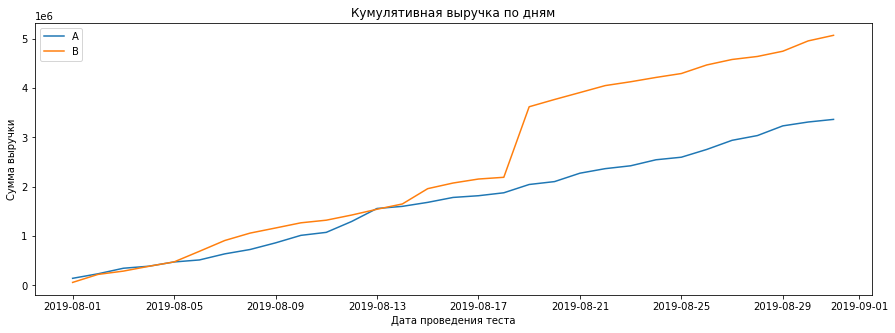

In [39]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(15, 5))# задаём размер сетки для графиков
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xlabel('Дата проведения теста')
plt.ylabel('Сумма выручки')
plt.title('Кумулятивная выручка по дням')
plt.legend();

Выручка почти равномерно увеличивается в течение всего теста. Однако график выручки группы В в одной точке резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. \
Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

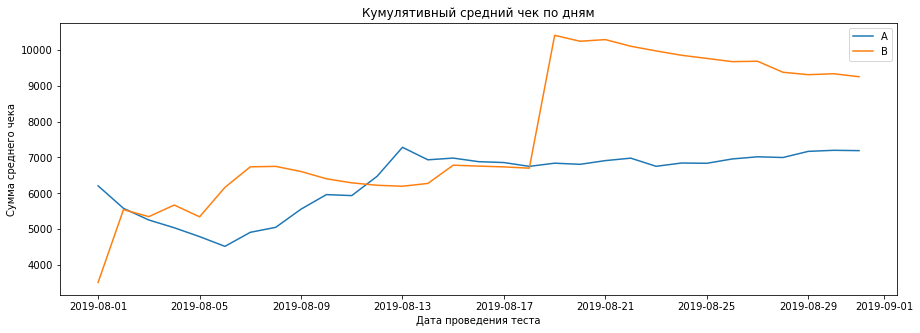

In [40]:
plt.figure(figsize=(15, 5))# задаём размер сетки для графиков
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel('Дата проведения теста')
plt.ylabel('Сумма среднего чека')
plt.title('Кумулятивный средний чек по дням')
plt.legend();

Средний чек тоже становится равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B. Однако мы также видим резкий скачок, скорее всего во второй половине тесте в группу В попали крупные заказы. 

Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Добавим горизонтальную ось методом `.axhline()`:

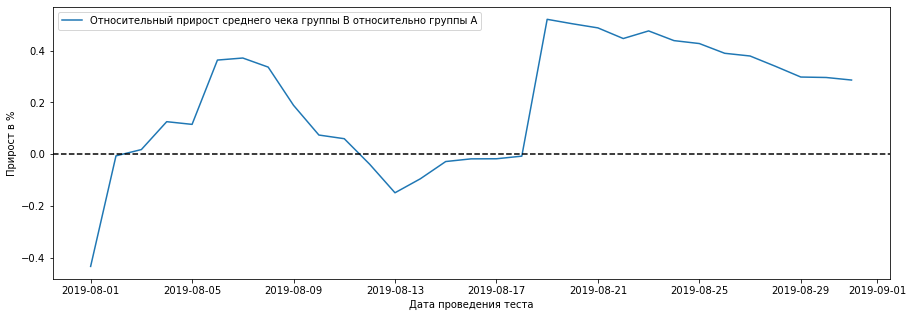

In [42]:
plt.figure(figsize=(15, 5))# задаём размер сетки для графиков
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1,
        label="Относительный прирост среднего чека группы B относительно группы A")
plt.legend()
plt.xlabel('Дата проведения теста')
plt.ylabel('Прирост в %')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

В нескольких точках график различия между сегментами резко «скачет». Очевидно, что необходимо делать анализ выбросов.\
Аналогично проанализируем график кумулятивной конверсии. Зададим масштаб осей методом plt.axis(). Передадим ему минимальное и максимальное значения оси x; минимальное и максимальное значения оси y — ["2019-08-01", '2019-08-31', 0.2, 0.05]:

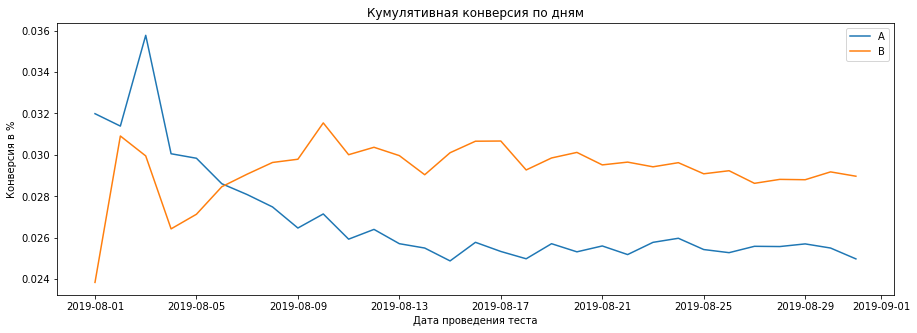

In [43]:
plt.figure(figsize=(15, 5))# задаём размер сетки для графиков
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xlabel('Дата проведения теста')
plt.ylabel('Конверсия в %')
plt.title('Кумулятивная конверсия по дням');


Судя по полученному графику, изначально лидировала группа А, однако в первой половине теста группа В вырвалась вперед и зафиксировала свою позицию. Группа А также зафкисировала свою позицию. Построим график относительного различия кумулятивных конверсий:

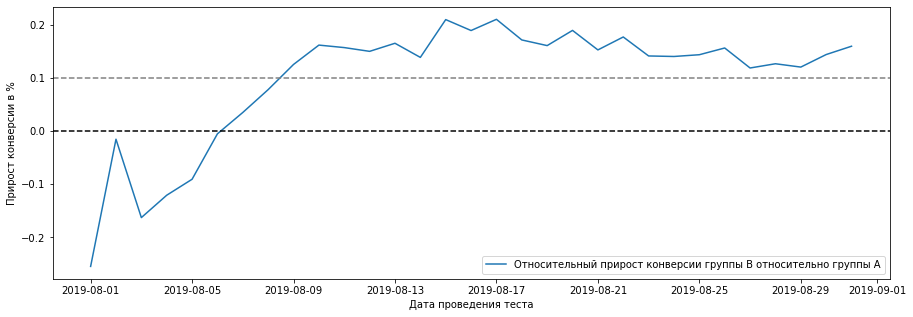

In [44]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15, 5))# задаём размер сетки для графиков
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xlabel('Дата проведения теста')
plt.ylabel('Прирост конверсии в %');

В начале теста группа B заняла лидирующую позицию, однако кратковременно значительно проигрывала группе A, затем вырвалась вперёд. Далее конверсия группы В только росла и фиксировалась в пределах 10-20%. В целом можно сказать что отношение конверсии установилось, но делать выводы рано, т.к. необходимо проанализировать аномалии.

### Анализ выбросов 

Оценим выбросы в заказах построив точечный график количества заказов по пользователям. Для этого создадим датафрейм с двумя столбцами `visitorId` и `transactionId` и построим диаграмму методом `scatter()`.

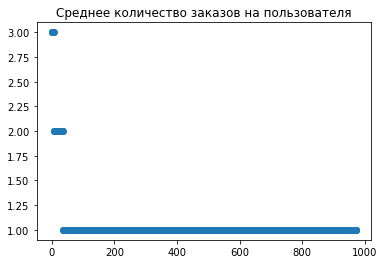

In [62]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
    .sort_values(by='transactionId', ascending=False)
)
ordersByUsers.columns = ['userId', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))# серия из чисел от 0 до количества наблюдений в ordersByUsers
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Среднее количество заказов на пользователя'); 

Итак, мы видим, что основная масса пользователей сделала не более одного заказа, а пользователей сделавших 2-3 заказа очень мало. Посчитаем выборочные перцентили. 

In [46]:
# Метод np.percentile('column', [percentile1, percentile2, percentile3]) находит перцентили.
print(np.percentile(ordersByUsers['orders'], [ 95, 99])) 

[1. 2.]


Таким образом, мы видим, что не более 5% пользователей совершали больше двух заказов. И не более 1% пользователей  больше двух заказов.

В этом случае оставим границу для определения аномальных пользователей - 2 заказа.
Аналогично проанализируем стоимость всех заказов.

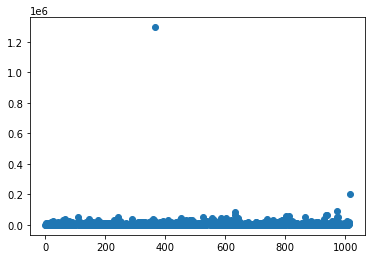

In [47]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']); 

Итак, мы определили только 2 выброса во всем датафрейме по стоимости заказов - один около 200 тыс руб, второй - более 1 млн.руб, что значительно больше чем все остальные заказы. Посмотрим на график без этого выброса. 

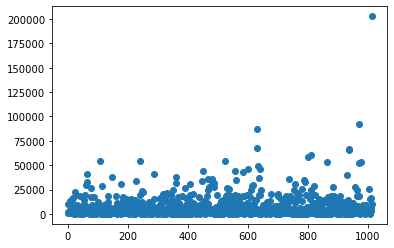

In [48]:
orders_no_mln = orders.query('revenue<1000000')
x_values = pd.Series(range(0, len(orders_no_mln['revenue'])))

plt.scatter(x_values, orders_no_mln['revenue']); 

Удалив 1 выброс, мы можем увидеть, что в основном стоимость всех заказов колеблется в пределах до 100 тыс. руб.Найдем выборочные перцентили.

In [49]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Итак, по стоимости заказов мы смогли установить, что не более 5% пользователей делают покупки более чем на 26 тыс. руб. и лишь 1% пользователей совершает покупки дороже 58 тыс. руб. В этом случае граница по аномальным заказам - 53904 руб.

Мы определили границы для определения аномальных пользователей и аномальных заказов. Таким образом, мы можем посчитать статистическую значимость различий в конверсии и среднем чеке между группами как по "сырым " данным, так и по "очищенным".

### Cтатистическая значимость различий

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей. Для анализа будем использовать непараметрический тест Уилкоксона-Манна-Уитни. 
Сформулируем гипотезы. Нулевая: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть.

Для начала подготовим данные:

In [65]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data['ConversionA'] = data['ordersPerDateA'] / data['visitorsPerDateA']
data['ConversionCummulativeA'] = data['ordersCummulativeA'] / data['visitorsCummulativeA']
data['ConversionB'] = data['ordersPerDateB'] / data['visitorsPerDateB']
data['ConversionCummulativeB'] = data['ordersCummulativeB'] / data['visitorsCummulativeB']

data.head(3)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB,ConversionA,ConversionCummulativeA,ConversionB,ConversionCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713,0.031989,0.031989,0.023843,0.023843
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294,0.030695,0.031390,0.039587,0.030912
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803,0.047337,0.035772,0.027505,0.029950


Напомним названия столбцов данных:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B;
- ConversionA - конверсия пользователей в выбранную дату в группе A;
- ConversionCummulativeA - накопительная конверсия пользователей до выбранной даты в группе A;
- ConversionB - конверсия пользователей в выбранную дату в группе B;
- ConversionCummulativeB - накопительная конверсия пользователей до выбранной даты в группе B.

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке гипотезы о равенстве долей.

In [51]:
#cписки с количеством заказов для каждого из пользователей:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

#число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов.
sampleA = pd.concat(# объединяем последовательности 
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(#создает список индексов в формате np.array, который требуется в pd.Series
                visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders']) #Нули для пользователей
                #которые ничего не заказывали. Их количество равно разнице между суммой посетителей 
                #и количеством записей о заказах
            ),
            name='orders',
        ),
    ],
    axis=0, #объединение по строкам (то есть записать подряд)
)
#число элементов sampleB — это количество пользователей, сумма всех элементов — количество заказов.
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Выведем относительный прирост конверсии пользователей группы B: конверсия пользователей группы B / конверсия пользователей группы A - 1. Округлим до трёх знаков после запятой.

In [52]:
alpha = 0.05  # критический уровень статистической значимости

p_value =  stats.mannwhitneyu(sampleA, sampleB)[1]

print('p-значение: ', "{0:.3f}".format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )
print(
    'Относительный прирост конверсии пользователей группы B: ', 
      "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)
     )        


p-значение:  0.011
Отвергаем нулевую гипотезу: между долями есть значимая разница
Относительный прирост конверсии пользователей группы B:  0.160


Первое число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, мы отвергаем. Также мы видим, что конверсия группы B  выше конверсии группы А на 16%.\
Теперь проверим статистическую значимость различий в среднем чеке между сегментами при помощи непараметрического теста. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. Используем тот же метод - `st.mannwhitneyu()`.
Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.
А ещё найдём относительные различия в среднем чеке между группами:

In [53]:
alpha = 0.05  # критический уровень статистической значимости

results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
print('Относительный прирост среднего чека пользователей группы B: ', "{0:.2f}"
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))    

p-значение:  0.829
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительный прирост среднего чека пользователей группы B:  0.29


Вывод: По «сырым» данным различий в среднем чеке групп A и B нет.
Первое число — p-value = 0.729 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, не отвергаем. Однако относительный выигрыш группы B равен 29% обусловлен аномальными заказами, которые нам предстоит выявить.

Теперь мы можем очистить данные от аномалий и проверить как изменится статистическая значимость.\
Мы уже определили границы для удаления аномальных пользователей - с количеством заказов большего одного и стоимостью заказа более 53904 руб. Итак, нам нужно найти аномальные заказы, затем удалить пользователей, совершивших их. Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [54]:
limit_orders=np.percentile(ordersByUsers['orders'], [99])[0]
limit_orders

2.0

In [55]:
limit_revenue=np.percentile(orders['revenue'], [99])[0]
limit_revenue

53904.0

In [56]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > limit_orders]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > limit_orders]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > limit_revenue]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print("Количество аномальных пользователей - ",abnormalUsers.shape[0]) 
print(abnormalUsers.head(5))

Количество аномальных пользователей -  16
1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64


Итак, мы определили список из 16 аномальных пользователей, теперь можем проанализировать как их действия повлияли на результаты теста.\
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии пользователей между группами теста по очищенным данным. Сначала удалим аномальных пользователей по группам теста:

In [57]:
#исключаем ID пользователей из аномального списка 
orders_filtered = orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))]
                         
ordersADaily = (
    orders_filtered[orders_filtered['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders_filtered[orders_filtered['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data_filtered = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data_filtered['ConversionA'] = data_filtered['ordersPerDateA'] / data_filtered['visitorsPerDateA']
data_filtered['ConversionCummulativeA'] = data_filtered['ordersCummulativeA'] / data_filtered['visitorsCummulativeA']
data_filtered['ConversionB'] = data_filtered['ordersPerDateB'] / data_filtered['visitorsPerDateB']
data_filtered['ConversionCummulativeB'] = data_filtered['ordersCummulativeB'] / data_filtered['visitorsCummulativeB']

Данные готовы. Теперь можно повторить тест.

In [58]:
#cписки с количеством заказов для каждого из пользователей:
ordersByUsersA = (
    orders_filtered[orders_filtered['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders_filtered[orders_filtered['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

#число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов.
sampleA_f = pd.concat(# объединяем последовательности 
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(#создает список индексов в формате np.array, который требуется в pd.Series
                visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders']) #Нули для пользователей
                #которые ничего не заказывали. Их количество равно разнице между суммой посетителей 
                #и количеством записей о заказах
            ),
            name='orders',
        ),
    ],
    axis=0, #объединение по строкам (то есть записать подряд)
)
#число элементов sampleB — это количество пользователей, сумма всех элементов — количество заказов.
sampleB_f = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Выведем относительный прирост конверсии пользователей группы B: конверсия пользователей группы B / конверсия пользователей группы A - 1. Округлим до трёх знаков после запятой.

In [59]:
alpha = 0.05  # критический уровень статистической значимости

p_value =  stats.mannwhitneyu(sampleA_f, sampleB_f)[1]

print('p-значение: ', "{0:.3f}".format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )
print(
    'Относительный прирост конверсии пользователей группы B: ', 
      "{0:.3f}".format(sampleB_f.mean() / sampleA_f.mean() - 1)
     )        


p-значение:  0.007
Отвергаем нулевую гипотезу: между долями есть значимая разница
Относительный прирост конверсии пользователей группы B:  0.189


P-value стал еще меньше. Впрочем, прирост конверсии группы B стал больше. Очевидно, какая-то часть выбросов приходилась на группу А.  Проверим, произошло ли что-нибудь с результатами по среднему чеку?

In [60]:
alpha = 0.05  # критический уровень статистической значимости

results = stats.mannwhitneyu(orders_filtered[orders_filtered['group']=='A']['revenue'], orders_filtered[orders_filtered['group']=='B']['revenue'])

print('p-значение: ', "{0:.3f}".format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
print('Относительный прирост среднего чека пользователей группы B: ', "{0:.3f}"
      .format(orders_filtered[orders_filtered['group']=='B']['revenue'].mean()/orders_filtered[orders_filtered['group']=='A']['revenue'].mean()-1))   

p-значение:  0.788
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
Относительный прирост среднего чека пользователей группы B:  -0.032


P-value снизился, но не значительно, но разница между сегментами изменилась в обратную сторону с 29% до -3%.

## Общий вывод

Мы провели анализ А/В теста и обнаружили:
1. При анализе кумулятивных метрик все время лидировала группа В, особенно хорошо это показал график кумулятивного среднего чека.
2. В данных есть аномалии как по количеству заказов, так и по их стоимости. Количество аномалий небольшое, но оно оказывало  влияние на результаты теста.
3. В анализе первоначальных данных мы нашли статистическую значимость различий в конверсии между группами, но не в среднем чеке. При этом наблюдался очевидный прирост группы В к группе А по обоим показателям. 
4. После очищения данных от аномалий статическая значимость различий не изменилась, но мы обнаружили что в среднем чеке лидерство заняла группа А.

Таким образом, мы выяснили, что даже после очищения данных, пользователи группы В стабильно лучше конвертируются в покупателей, несмотря на небольшое отставание от группы А по среднему чеку. При этом мы доказали статистическую значимость различия по конверсии. Что значит с ростом конверсии будет расти и выручка при неизменном среднем чеке. Поэтому мы можем остановить тест и признать его успешным. 